In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
from time import sleep
import os 
import glob
import json
from pandas.plotting import scatter_matrix as sm
import matplotlib.pyplot as plt
import scipy
import matplotlib as mpl
from chime_frb_constants import K_DM, FREQ_BOTTOM_MHZ, FREQ_TOP_MHZ
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 24
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

In [3]:
data_basecat = pd.read_json('/arc/home/ksand/Basecat_morph/Basecat_morph.json') #### Loading basecat information ####
data_basecat['Ratio(w/s)'] = round(data_basecat['Min_width(s)']/data_basecat['Scattering(s)'],2)
data_basecat['DM_eg'] = data_basecat['DM'] - data_basecat['MW_DM']
data_basecat['RM_eg'] = data_basecat['RM'] - data_basecat['MW_RM']
data_basecat['RM_eg_err'] = np.sqrt(data_basecat['RM_err']**2 + data_basecat['MW_RM_err']**2)
# data_basecat['Sc_eg'] = data_basecat['Scattering(s)'] #- data_basecat['MW_scat']


### arranging scattering limits less than expected from galaxy #####

sc_all = data_basecat['Scattering(s)'].to_numpy()
ev = data_basecat['Event'].to_numpy()
sc_gal = data_basecat['MW_scat'].to_numpy()
sc_eg_mod = np.zeros(len(ev))


for i in range(len(sc_all)):
    if sc_gal[i] > sc_all[i]:
        sc_eg_mod[i] = sc_gal[i]
    else:
        sc_eg_mod[i] = sc_all[i]
    # print(sc_eg[i], sc_eg_mod[i])

data_basecat['Sc_eg'] = sc_eg_mod.tolist()



# data_only_scat = data_basecat[(data_basecat['Fit_type'] == 'Scint') | (data_basecat['Fit_type'] == 'Scat')]

# data_no_scint = data_basecat[(data_basecat['Fit_type'] != 'Scint')]

data_final_basecat = data_basecat[(data_basecat['Min_width(s)'] > 5e-6)]
# data_final_basecat = data_final_basecat[(data_final_basecat['Min_width_err(s)'] < data_final_basecat['Min_width(s)'])]
# data_final_basecat = data_final_basecat.dropna()
print(len(data_final_basecat))

data_final_basecat_no_profile = data_final_basecat[(data_final_basecat['Fit_type'] != 'Profile')]
data_final_basecat_only_profile = data_final_basecat[(data_final_basecat['Fit_type'] == 'Profile')]

#print(len(data_final_basecat_no_profile))

data_only_scat_final = data_final_basecat[(data_final_basecat['Fit_type'] == 'Scint') | (data_final_basecat['Fit_type'] == 'Scat')]
data_no_scat_final = data_final_basecat[(data_final_basecat['Fit_type'] == 'Noscat')]

#display(data_no_scat_final)

137


87 84


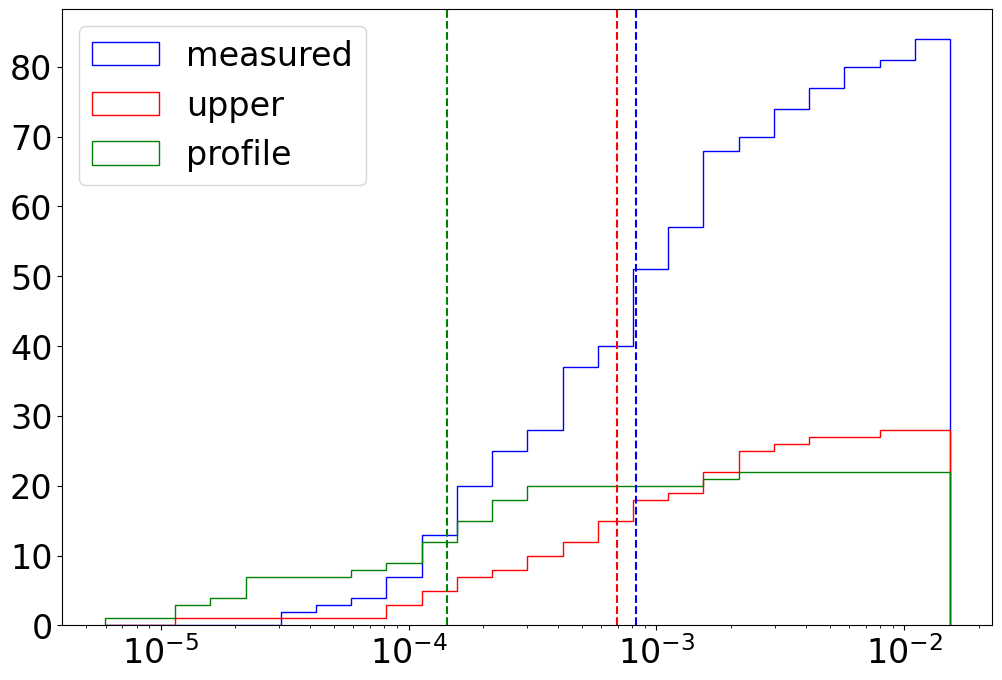

In [4]:
##### Mean standard deviation analysis #####

sc_measured = data_only_scat_final['Scattering(s)'].to_numpy()
events_measured = data_only_scat_final['Event'].to_numpy()
sc_all = data_final_basecat['Scattering(s)'].to_numpy()

sc_upper = data_no_scat_final['Scattering(s)'].to_numpy()

sc_profile = data_final_basecat_only_profile['Scattering(s)'].to_numpy()


### Removing events with scattering close to galactic #####
rm_events = np.array([25660576, 39069820, 41252817])
id_x = []
for ev in rm_events:
    i = np.where(events_measured == ev)[0][0]
    id_x.append(i)
    
id_x = np.array(id_x)

sc_measured_del = np.delete(sc_measured, id_x)
print(len(sc_measured),len(sc_measured_del))


bins=25
hist, bins_w = np.histogram(sc_all, bins=bins)
logbins = np.logspace(np.log10(bins_w[0]), np.log10(bins_w[-1]), bins)

# res = scipy.stats.cumfreq(sc_measured, numbins=bins)
 
# x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)

#plt.hist(sc_all, bins=logbins, alpha=1, edgecolor='b', color='royalblue', histtype='step', cumulative=True)
plt.hist(sc_measured_del, bins=logbins, alpha=1, edgecolor='b', color='royalblue', histtype='step', cumulative=True, label='measured')
plt.hist(sc_upper, bins=logbins, alpha=1, edgecolor='r', color='r', histtype='step', cumulative=True, label = 'upper')
plt.hist(sc_profile, bins=logbins, alpha=1, edgecolor='g', color='g', histtype='step', cumulative=True, label='profile')

plt.axvline(np.median(sc_measured_del), c='b', linestyle='--')
plt.axvline(np.median(sc_upper), c='r', linestyle='--')
plt.axvline(np.median(sc_profile), c='g', linestyle='--')
# plt.bar(x, x, color='orange')

plt.xscale('log')
plt.legend()

plt.show()

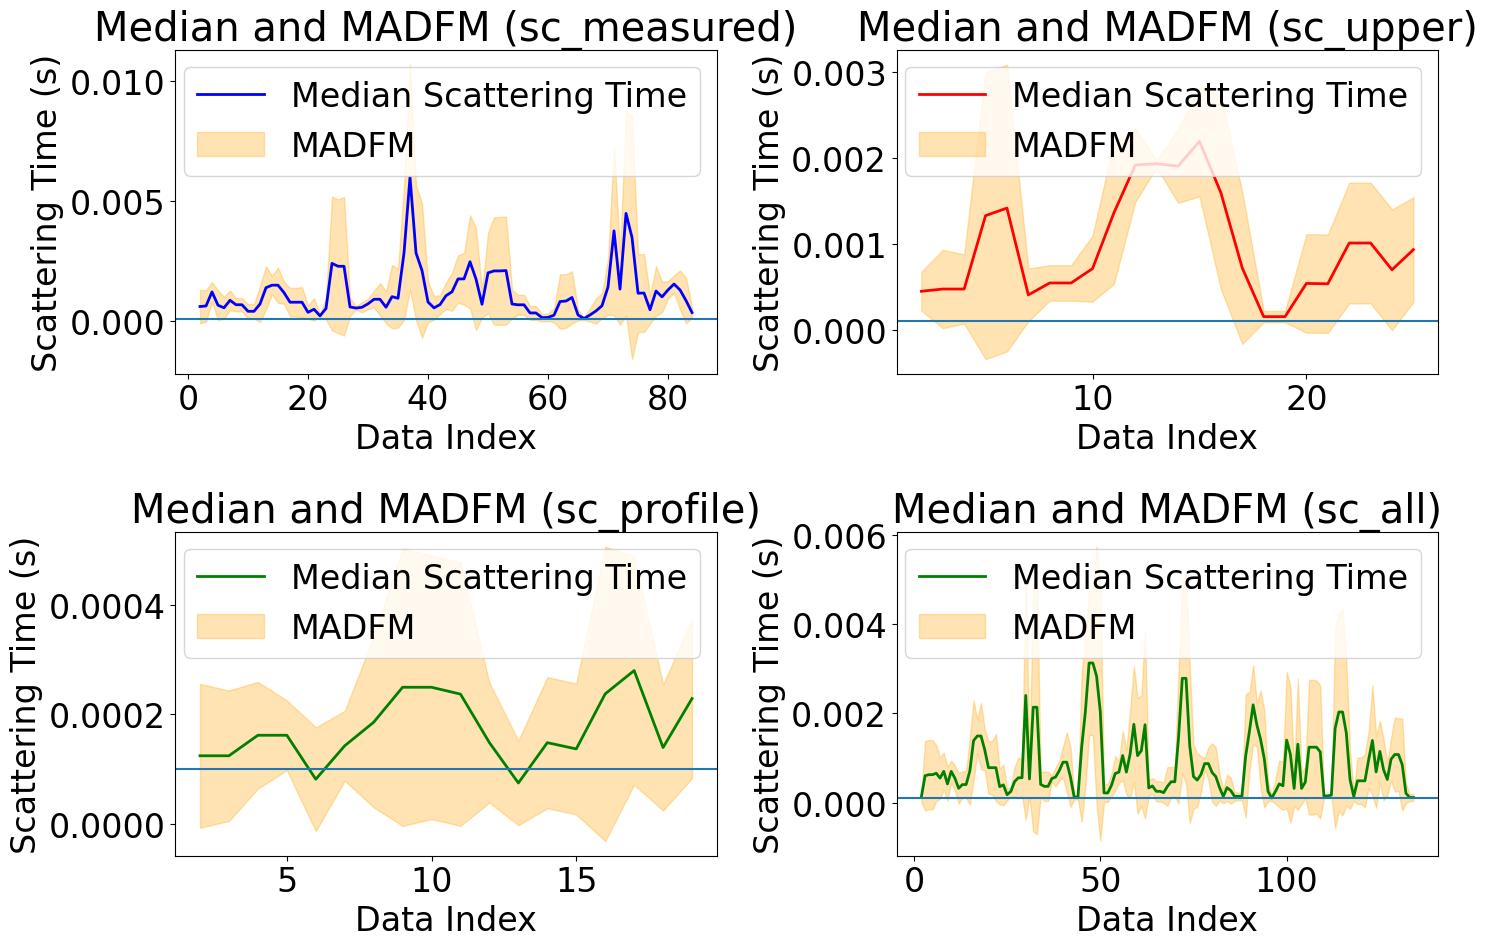

In [5]:


# Parameters
window_size = 5  # Define the window size
half_window = window_size // 2
step_size = 1  # Step size for the sliding window

def sliding_window_median_madfm(data, window_size, step_size):
    """ Calculate the median and MADFM using a sliding window """
    medians = []
    madfms = []
    window_centers = []

    for i in range(half_window, len(data) - half_window, step_size):
        window_data = data[i - half_window:i + half_window]
        median = np.median(window_data)
        madfm = scipy.stats.median_abs_deviation(window_data, scale='normal')  # MADFM scaled to std. dev.
        medians.append(median)
        madfms.append(madfm)
        window_centers.append(i)

    return window_centers, medians, madfms

# Prepare subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot for sc_measured
window_centers, medians, madfms = sliding_window_median_madfm(sc_measured, window_size, step_size)
axs[0][0].plot(window_centers, medians, label='Median Scattering Time', color='blue', lw=2)
axs[0][0].fill_between(window_centers, np.array(medians) - np.array(madfms),
                    np.array(medians) + np.array(madfms), color='orange', alpha=0.3, label='MADFM')
# axs[0].set_ylim(1e-6, np.max(sc_all)+0.01)
# axs[0].set_yscale('log')
axs[0][0].set_xlabel('Data Index')
axs[0][0].set_ylabel('Scattering Time (s)')
axs[0][0].set_title('Median and MADFM (sc_measured)')
axs[0][0].axhline(1e-4)
axs[0][0].legend()

# Plot for sc_upper
window_centers, medians, madfms = sliding_window_median_madfm(sc_upper, window_size, step_size)
axs[0][1].plot(window_centers, medians, label='Median Scattering Time', color='red', lw=2)
axs[0][1].fill_between(window_centers, np.array(medians) - np.array(madfms),
                    np.array(medians) + np.array(madfms), color='orange', alpha=0.3, label='MADFM')
# axs[1].set_ylim(1e-6, np.max(sc_all)+0.01)
# axs[1].set_yscale('log')
axs[0][1].set_xlabel('Data Index')
axs[0][1].set_ylabel('Scattering Time (s)')
axs[0][1].set_title('Median and MADFM (sc_upper)')
axs[0][1].axhline(1e-4)
axs[0][1].legend()

# Plot for sc_profile
window_centers, medians, madfms = sliding_window_median_madfm(sc_profile, window_size, step_size)
axs[1][0].plot(window_centers, medians, label='Median Scattering Time', color='green', lw=2)
axs[1][0].fill_between(window_centers, np.array(medians) - np.array(madfms),
                    np.array(medians) + np.array(madfms), color='orange', alpha=0.3, label='MADFM')
# axs[2].set_ylim(1e-6, np.max(sc_all)+0.01)
# axs[2].set_yscale('log')
axs[1][0].set_xlabel('Data Index')
axs[1][0].set_ylabel('Scattering Time (s)')
axs[1][0].set_title('Median and MADFM (sc_profile)')
axs[1][0].axhline(1e-4)
axs[1][0].legend()


window_centers, medians, madfms = sliding_window_median_madfm(sc_all, window_size, step_size)
axs[1][1].plot(window_centers, medians, label='Median Scattering Time', color='green', lw=2)
axs[1][1].fill_between(window_centers, np.array(medians) - np.array(madfms),
                    np.array(medians) + np.array(madfms), color='orange', alpha=0.3, label='MADFM')
# axs[2].set_ylim(1e-6, np.max(sc_all)+0.01)
# axs[2].set_yscale('log')
axs[1][1].set_xlabel('Data Index')
axs[1][1].set_ylabel('Scattering Time (s)')
axs[1][1].set_title('Median and MADFM (sc_all)')
axs[1][1].axhline(1e-4)
axs[1][1].legend()

# Adjust layout and show plot
plt.tight_layout()
# plt.savefig('Sc_median_MADFM.jpg', bbox_inches='tight', dpi=300)
plt.show()


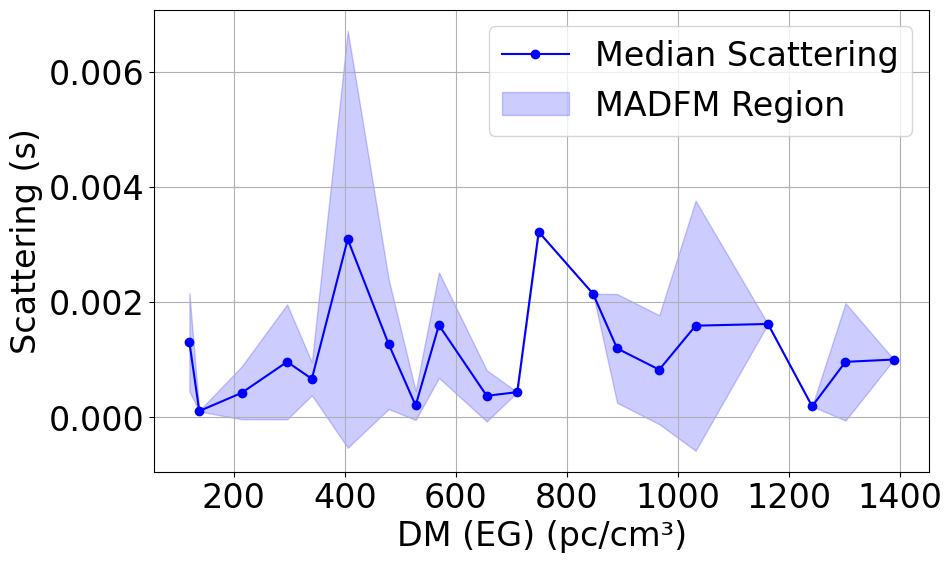

In [30]:


scattering = sc_measured  # Replace with actual scattering data
dm = data_only_scat_final['DM_eg'].to_numpy()  # Replace with actual DM data

rm_events = np.array([25660576, 39069820, 41252817])
id_x = []
for ev in rm_events:
    i = np.where(events_measured == ev)[0][0]
    id_x.append(i)
    
id_x = np.array(id_x)

scattering = np.delete(scattering, id_x)
dm = np.delete(dm, id_x)
# print(len(sc_measured),len(sc_measured_del))

# Define the number of bins for DM
bins = np.linspace(dm.min(), dm.max(), 25)

# Bin the DM values
dm_bins = np.digitize(dm, bins)

# Prepare lists to store results
mad_values = []
med_values = []
dm_medians = []

for i in range(1, len(bins)):
    # Select data for this bin
    bin_mask = (dm_bins == i)
    scatter_in_bin = scattering[bin_mask]
    
    # If bin has enough data points, calculate MADFM and median
    if len(scatter_in_bin) > 0:
        mad = scipy.stats.median_abs_deviation(scatter_in_bin, scale='normal')
        median_scatter = np.median(scatter_in_bin)
        
        mad_values.append(mad)
        med_values.append(median_scatter)
        
        # Use median DM value of the bin as the representative DM
        dm_medians.append(np.median(dm[bin_mask]))

# Convert lists to arrays for easier plotting
dm_medians = np.array(dm_medians)
med_values = np.array(med_values)
mad_values = np.array(mad_values)

# Plotting
plt.figure(figsize=(10, 6))

# Plot Median of Scattering
plt.plot(dm_medians, med_values, marker='o', linestyle='-', color='b', label='Median Scattering')

# Plot shaded region for MADFM around the median
plt.fill_between(dm_medians, med_values - mad_values, med_values + mad_values, color='b', alpha=0.2, label='MADFM Region')

plt.xlabel('DM (EG) (pc/cm³)')
plt.ylabel('Scattering (s)')
# plt.title('Median Scattering with MADFM Shaded Region vs Dispersion Measure (DM)')
plt.grid(True)
plt.legend()
# plt.xscale('log')
# plt.yscale('log')  # Log scale if you have wide variations in the data
plt.show()

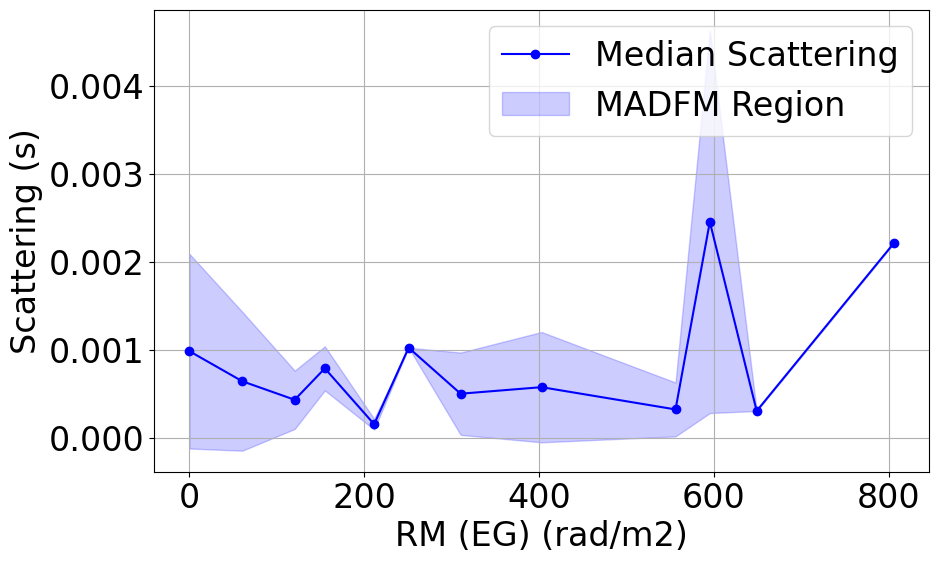

In [31]:


scattering = sc_measured  # Replace with actual scattering data
rm = data_only_scat_final['RM_eg'].to_numpy()  # Replace with actual DM data

rm_events = np.array([25660576, 39069820, 41252817])
id_x = []
for ev in rm_events:
    i = np.where(events_measured == ev)[0][0]
    id_x.append(i)
    
id_x = np.array(id_x)

scattering = np.delete(scattering, id_x)
rm = abs(np.delete(rm, id_x))
# print(len(sc_measured),len(sc_measured_del))

# Define the number of bins for DM
bins = np.linspace(rm.min(), rm.max(), 25)

# Bin the DM values
rm_bins = np.digitize(rm, bins)

# Prepare lists to store results
mad_values = []
med_values = []
rm_medians = []

for i in range(1, len(bins)):
    # Select data for this bin
    bin_mask = (rm_bins == i)
    scatter_in_bin = scattering[bin_mask]
    
    # If bin has enough data points, calculate MADFM and median
    if len(scatter_in_bin) > 0:
        mad = scipy.stats.median_abs_deviation(scatter_in_bin, scale='normal')
        median_scatter = np.median(scatter_in_bin)
        
        mad_values.append(mad)
        med_values.append(median_scatter)
        
        # Use median DM value of the bin as the representative DM
        rm_medians.append(np.median(rm[bin_mask]))

# Convert lists to arrays for easier plotting
rm_medians = np.array(rm_medians)
med_values = np.array(med_values)
mad_values = np.array(mad_values)

# Plotting
plt.figure(figsize=(10, 6))

# Plot Median of Scattering
plt.plot(rm_medians, med_values, marker='o', linestyle='-', color='b', label='Median Scattering')

# Plot shaded region for MADFM around the median
plt.fill_between(rm_medians, med_values - mad_values, med_values + mad_values, color='b', alpha=0.2, label='MADFM Region')

plt.xlabel('RM (EG) (rad/m2)')
plt.ylabel('Scattering (s)')
# plt.title('Median Scattering with MADFM Shaded Region vs Dispersion Measure (DM)')
plt.grid(True)
plt.legend()
# plt.xscale('log')
# plt.yscale('log')  # Log scale if you have wide variations in the data
plt.show()

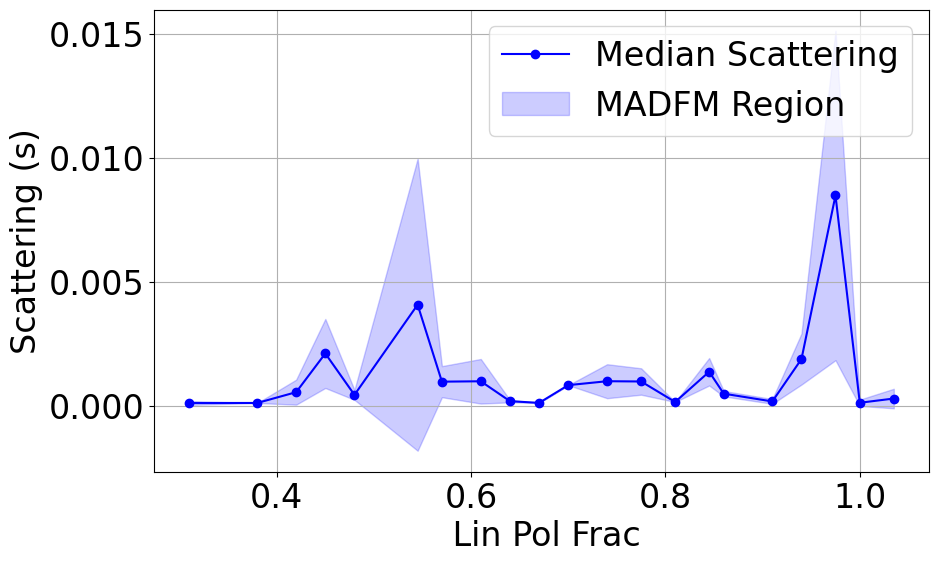

In [29]:
scattering = sc_measured

pol = data_only_scat_final['Pol_frac'].to_numpy()

id_x = np.where(pol == -1)[0]

scattering = np.delete(scattering, id_x)
pol = np.delete(pol, id_x)

bins = np.linspace(pol.min(), pol.max(), 25)

# Bin the DM values
pol_bins = np.digitize(pol, bins)

# Prepare lists to store results
mad_values = []
med_values = []
pol_medians = []

for i in range(1, len(bins)):
    # Select data for this bin
    bin_mask = (pol_bins == i)
    scatter_in_bin = scattering[bin_mask]
    
    # If bin has enough data points, calculate MADFM and median
    if len(scatter_in_bin) > 0:
        mad = scipy.stats.median_abs_deviation(scatter_in_bin, scale='normal')
        median_scatter = np.median(scatter_in_bin)
        
        mad_values.append(mad)
        med_values.append(median_scatter)
        
        # Use median DM value of the bin as the representative DM
        pol_medians.append(np.median(pol[bin_mask]))

# Convert lists to arrays for easier plotting
pol_medians = np.array(pol_medians)
med_values = np.array(med_values)
mad_values = np.array(mad_values)

# Plotting
plt.figure(figsize=(10, 6))

# Plot Median of Scattering
plt.plot(pol_medians, med_values, marker='o', linestyle='-', color='b', label='Median Scattering')

# Plot shaded region for MADFM around the median
plt.fill_between(pol_medians, med_values - mad_values, med_values + mad_values, color='b', alpha=0.2, label='MADFM Region')

plt.xlabel(' Lin Pol Frac')
plt.ylabel('Scattering (s)')
# plt.title('Median Scattering with MADFM Shaded Region vs Dispersion Measure (DM)')
plt.grid(True)
plt.legend()
# plt.xscale('log')
# plt.yscale('log')  # Log scale if you have wide variations in the data
plt.show()

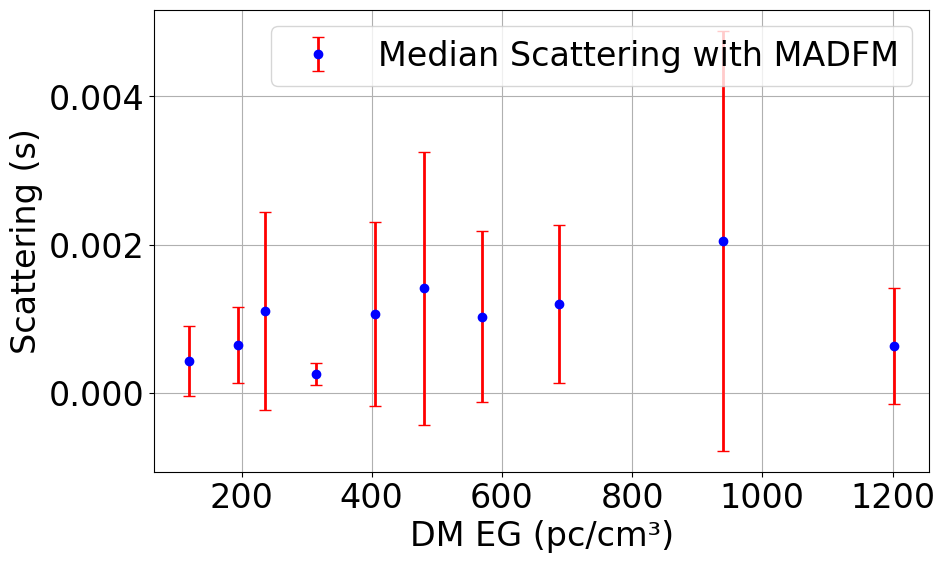

In [40]:


# Example data: replace with your actual data
scattering = sc_measured  # Replace with actual scattering data
dm = dm  # Replace with actual DM data

# Define the number of bins (equal number of points per bin)
n_bins = 10

# Sort the DM data and create quantile-based bins for equal points per bin
sorted_indices = np.argsort(dm)
sorted_dm = dm[sorted_indices]
sorted_scattering = scattering[sorted_indices]

# Calculate bin edges based on quantiles
quantile_edges = np.linspace(0, 1, n_bins + 1)
quantile_bins = np.quantile(sorted_dm, quantile_edges)

# Prepare lists to store results
mad_values = []
med_values = []
dm_medians = []

# Calculate MADFM and median for each quantile bin
for i in range(len(quantile_bins) - 1):
    bin_mask = (sorted_dm >= quantile_bins[i]) & (sorted_dm < quantile_bins[i + 1])
    scatter_in_bin = sorted_scattering[bin_mask]
    
    if len(scatter_in_bin) > 0:
        # Compute median and MADFM
        mad = scipy.stats.median_abs_deviation(scatter_in_bin, scale='normal')
        median_scatter = np.median(scatter_in_bin)
        
        mad_values.append(mad)
        med_values.append(median_scatter)
        
        # Use median DM value of the bin as the representative DM
        dm_medians.append(np.median(sorted_dm[bin_mask]))

# Convert lists to arrays for easier plotting
dm_medians = np.array(dm_medians)
med_values = np.array(med_values)
mad_values = np.array(mad_values)

# Plotting
plt.figure(figsize=(10, 6))

# Plot Median of Scattering with Error Bars for MADFM
plt.errorbar(dm_medians, med_values, yerr=mad_values, fmt='o', color='b', ecolor='r', 
             elinewidth=2, capsize=4, label='Median Scattering with MADFM')

plt.xlabel('DM EG (pc/cm³)')
plt.ylabel('Scattering (s)')
# plt.title('Median Scattering with MADFM Error Bars vs Dispersion Measure (DM)')
plt.grid(True)
plt.legend()
# plt.xscale('log')
# plt.yscale('log')  # Log scale if you have wide variations in the data
plt.savefig('DM_scat_madfm.pdf', bbox_inches='tight', dpi=300)
plt.show()


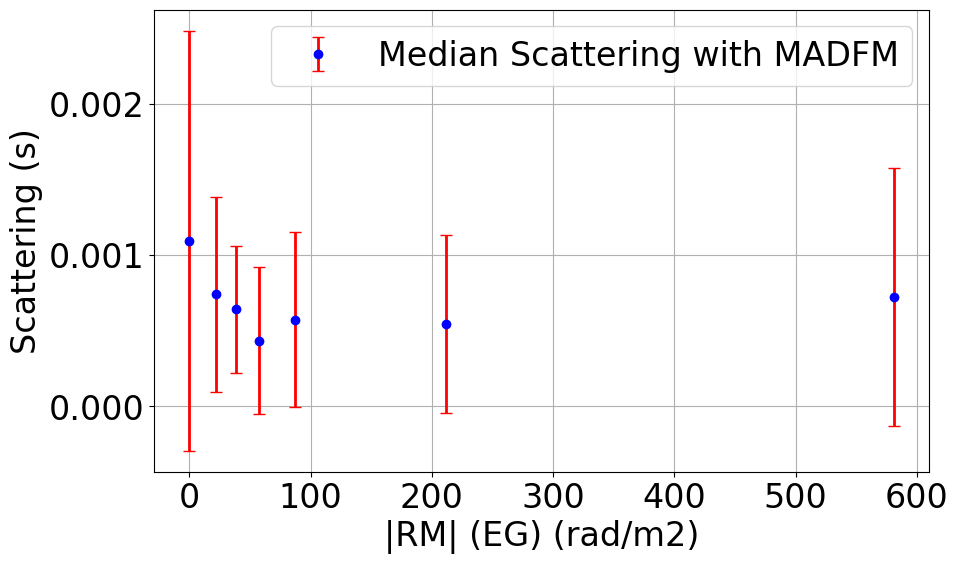

In [41]:
scattering = sc_measured  # Replace with actual scattering data
rm = abs(rm)  # Replace with actual DM data

# Define the number of bins (equal number of points per bin)
n_bins = 10

# Sort the DM data and create quantile-based bins for equal points per bin
sorted_indices = np.argsort(rm)
sorted_rm = rm[sorted_indices]
sorted_scattering = scattering[sorted_indices]

# Calculate bin edges based on quantiles
quantile_edges = np.linspace(0, 1, n_bins + 1)
quantile_bins = np.quantile(sorted_rm, quantile_edges)

# Prepare lists to store results
mad_values = []
med_values = []
rm_medians = []

# Calculate MADFM and median for each quantile bin
for i in range(len(quantile_bins) - 1):
    bin_mask = (sorted_rm >= quantile_bins[i]) & (sorted_rm < quantile_bins[i + 1])
    scatter_in_bin = sorted_scattering[bin_mask]
    
    if len(scatter_in_bin) > 0:
        # Compute median and MADFM
        mad = scipy.stats.median_abs_deviation(scatter_in_bin, scale='normal')
        median_scatter = np.median(scatter_in_bin)
        
        mad_values.append(mad)
        med_values.append(median_scatter)
        
        # Use median DM value of the bin as the representative DM
        rm_medians.append(np.median(sorted_rm[bin_mask]))

# Convert lists to arrays for easier plotting
rm_medians = np.array(rm_medians)
med_values = np.array(med_values)
mad_values = np.array(mad_values)

# Plotting
plt.figure(figsize=(10, 6))

# Plot Median of Scattering with Error Bars for MADFM
plt.errorbar(rm_medians, med_values, yerr=mad_values, fmt='o', color='b', ecolor='r', 
             elinewidth=2, capsize=4, label='Median Scattering with MADFM')

plt.xlabel('|RM| (EG) (rad/m2)')
plt.ylabel('Scattering (s)')
# plt.title('Median Scattering with MADFM Error Bars vs Dispersion Measure (DM)')
plt.grid(True)
plt.legend()
# plt.xscale('log')
# plt.yscale('log')  # Log scale if you have wide variations in the data
plt.savefig('RM_scat_madfm.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
scattering = sc_measured  # Replace with actual scattering data
pol = pol  # Replace with actual DM data

# Define the number of bins (equal number of points per bin)
n_bins = 10

# Sort the DM data and create quantile-based bins for equal points per bin
sorted_indices = np.argsort(pol)
sorted_pol = pol[sorted_indices]
sorted_scattering = scattering[sorted_indices]

# Calculate bin edges based on quantiles
quantile_edges = np.linspace(0, 1, n_bins + 1)
quantile_bins = np.quantile(sorted_pol, quantile_edges)

# Prepare lists to store results
mad_values = []
med_values = []
pol_medians = []

# Calculate MADFM and median for each quantile bin
for i in range(len(quantile_bins) - 1):
    bin_mask = (sorted_pol >= quantile_bins[i]) & (sorted_pol < quantile_bins[i + 1])
    scatter_in_bin = sorted_scattering[bin_mask]
    
    if len(scatter_in_bin) > 0:
        # Compute median and MADFM
        mad = scipy.stats.median_abs_deviation(scatter_in_bin, scale='normal')
        median_scatter = np.median(scatter_in_bin)
        
        mad_values.append(mad)
        med_values.append(median_scatter)
        
        # Use median DM value of the bin as the representative DM
        pol_medians.append(np.median(sorted_pol[bin_mask]))

# Convert lists to arrays for easier plotting
pol_medians = np.array(pol_medians)
med_values = np.array(med_values)
mad_values = np.array(mad_values)

# Plotting
plt.figure(figsize=(10, 6))

# Plot Median of Scattering with Error Bars for MADFM
plt.errorbar(pol_medians, med_values, yerr=mad_values, fmt='o', color='b', ecolor='r', 
             elinewidth=2, capsize=4, label='Median Scattering with MADFM')

plt.xlabel('Linear Polarization Fraction')
plt.ylabel('Scattering (s)')
# plt.title('Median Scattering with MADFM Error Bars vs Dispersion Measure (DM)')
plt.grid(True)
plt.legend()
# plt.xscale('log')
# plt.yscale('log')  # Log scale if you have wide variations in the data
plt.savefig('Pol_scat_madfm.pdf', bbox_inches='tight', dpi=300)
plt.show()